# This notebook adapts the code from [Eric Jang's blogpost on Normalizing Flows](https://blog.evjang.com/2018/01/nf1.html) to Tensorflow 2.0 and Keras.

In [1]:
# See https://github.com/tensorflow/tensorflow/issues/31249
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import layers

tfd = tfp.distributions
tfb = tfp.bijectors

# Data

In [2]:
batch_size=512
x2_dist=tfd.Normal(loc=0., scale=4.)
x2_samples = x2_dist.sample(batch_size)
x1 = tfd.Normal(loc=.25 * tf.square(x2_samples),
                scale=tf.ones(batch_size, dtype=tf.float32))
x1_samples = x1.sample()
x_samples = tf.stack([x1_samples, x2_samples], axis=1)

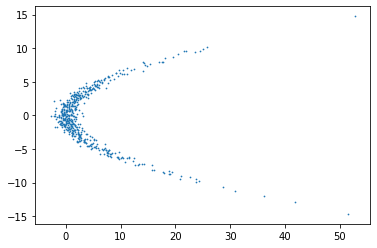

In [3]:
plt.scatter(x_samples[:,0], x_samples[:,1], s=.5)

# Layers

In [4]:
class LeakyReLU(tfb.Bijector):
    def __init__(self, alpha=.5, validate_args=True, name="leaky_relu"):
        super().__init__(inverse_min_event_ndims=0, validate_args=validate_args, name=name)
        self.alpha = alpha
    
    def _forward(self, x):
        return tf.where(tf.greater_equal(x, 0), x, self.alpha * x)
    
    def _inverse(self, y):
        return tf.where(tf.greater_equal(y, 0), y, 1./ self.alpha*y)
    
    def _inverse_log_det_jacobian(self, y):
        I = tf.ones_like(y)
        J_inv = tf.where(tf.greater_equal(y, 0), I, 1/self.alpha * I)
        log_abs_det_j_inv = tf.math.log(tf.math.abs(J_inv))
        return log_abs_det_j_inv


In [5]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], tf.float32))
def get_dist(var_list, num_layers):
    bijectors = []
    for i in range(num_layers):
        V = var_list[4*i]
        shift = var_list[4*i+1]
        L = var_list[4*i+2]
        alpha = var_list[4*i+3] + .1
        bijectors.append(tfb.Affine(
            scale_tril=tfd.fill_triangular(L),
            scale_perturb_factor=V,
            shift=shift,))
        if i in range(num_layers-1):
            bijectors.append(LeakyReLU(alpha=alpha))
    mlp_bijector = tfb.Chain(list(reversed(bijectors)), name='2d_mlp_bijector')
    dist = tfd.TransformedDistribution(
        distribution=base_dist,
        bijector=mlp_bijector
    )
    return dist

In [6]:
class NormalizingFlow(layers.Layer):

    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        self.var_list = []
        d, r = 2, 2
        DTYPE = tf.float32
        self.num_layers = 5
        for i in range(self.num_layers):
            V = self.add_weight(name=f'V{i}', shape=[d,r], initializer=tf.compat.v1.glorot_uniform_initializer())
            shift = self.add_weight(name=f'shift{i}', shape=[d], initializer=tf.compat.v1.glorot_uniform_initializer())
            L = self.add_weight(name=f'L{i}', shape=[int(d * (d+1)/2)], initializer=tf.compat.v1.glorot_uniform_initializer())
            if i in range(self.num_layers-1):
                alpha = self.add_weight(name=f'alpha{i}', shape=[], initializer=tf.compat.v1.glorot_uniform_initializer())
            self.var_list.extend([V, shift, L, alpha])

    def call(self, inputs):
        dist = get_dist(self.var_list, self.num_layers)
        return dist.log_prob(inputs)

In [7]:
class LossLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(-tf.reduce_mean(inputs))
        return inputs  # Pass-through layer.

# Model instantiation and training

In [8]:
inputs = keras.Input(shape=x_samples.shape[-1], name='x_samples')
log_probs = NormalizingFlow()(inputs)
outputs = LossLayer(name='loss_layer')(log_probs)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))

dataset = tf.data.Dataset.from_tensors((x_samples, [])).repeat(2_000)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='normalizing_flow_{epoch}',
        save_weights_only=True,
#         save_freq=512*200,
        monitor='loss',
        verbose=1)
]

W0809 16:17:19.196716 139698974025536 training_utils.py:1237] Output loss_layer missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to loss_layer.


In [9]:
# model.load_weights('normalizing_flow_1')

In [16]:
model.fit(x=dataset, y=None, epochs=5, callbacks=callbacks)

W0809 16:21:24.397531 139698974025536 training_utils.py:1436] Expected a shuffled dataset but input dataset `x` is not shuffled. Please invoke `shuffle()` on input dataset.


Epoch 1/5
1993/2000 [============================>.] - ETA: 0s - loss: 4.3265
Epoch 00001: saving model to normalizing_flow_1
2000/2000 [==============================] - 11s 6ms/step - loss: 4.3265
Epoch 2/5
1998/2000 [============================>.] - ETA: 0s - loss: 4.2930
Epoch 00002: saving model to normalizing_flow_2
2000/2000 [==============================] - 12s 6ms/step - loss: 4.2930
Epoch 3/5
1995/2000 [============================>.] - ETA: 0s - loss: 4.4901
Epoch 00003: saving model to normalizing_flow_3
2000/2000 [==============================] - 21s 10ms/step - loss: 4.4901
Epoch 4/5
1999/2000 [============================>.] - ETA: 0s - loss: 4.4055
Epoch 00004: saving model to normalizing_flow_4
2000/2000 [==============================] - 13s 6ms/step - loss: 4.4054
Epoch 5/5
1993/2000 [============================>.] - ETA: 0s - loss: 3.9889
Epoch 00005: saving model to normalizing_flow_5
2000/2000 [==============================] - 14s 7ms/step - loss: 3.9888


# Visualization

In [17]:
dist = get_dist(model.layers[1].var_list, num_layers=5)
res = dist.sample(512)

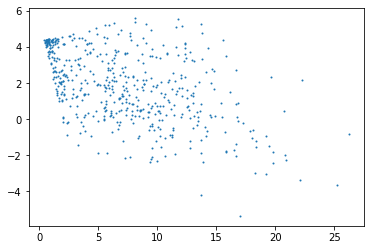

In [18]:
plt.scatter(res[:,0], res[:,1], s=1)

In [19]:
# visualization
x = base_dist.sample(512)
samples = [x]
names = [base_dist.name]
for bijector in reversed(dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

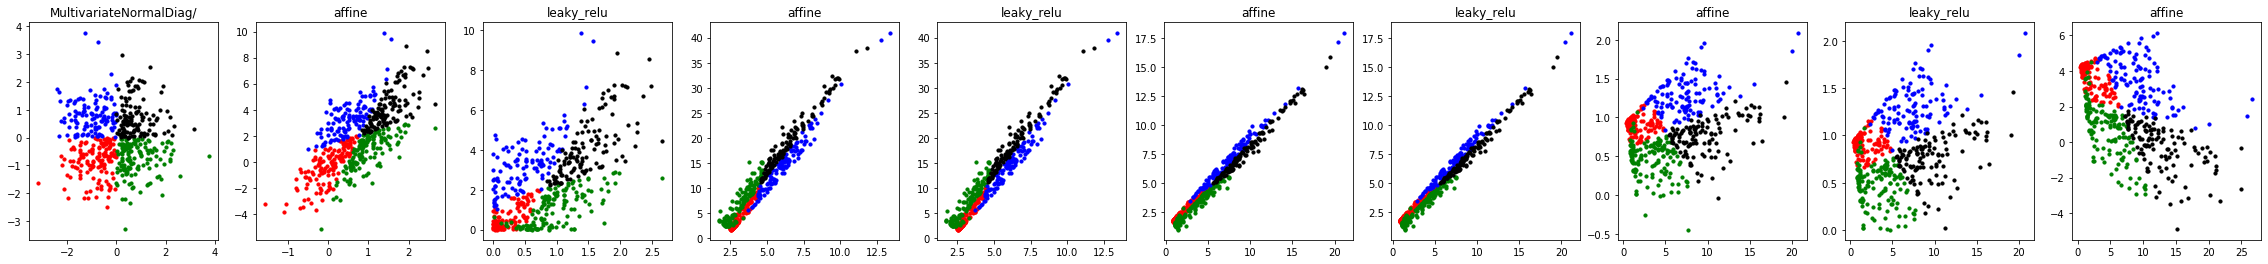

In [20]:
results = samples
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0].numpy()
for i in range(len(results)):
    X1 = results[i].numpy()
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_title(names[i])